<a href="https://colab.research.google.com/github/poojarinaresh/Amazon_Shopping_Clone/blob/main/asl_alphabet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASL-Alphabet Classification

This small notebook contains approaches to classify letter/alphabet images that contain gestures of the American Sign Language (ASL). Deep Learning models are used with Keras, including CNNs defined from scratch, transfer learning with models pre-trained on ImageNet and autoencoders in combination with random forests.

The original dataset can be downloaded from Kaggle: [asl-alphabet](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). Download from [here](https://www.kaggle.com/datasets/grassknoted/asl-alphabet/download?datasetVersionNumber=1).

**See the co-located [`README.md`](README.md) file for more information and the preliminary conclusions.**

Table of Contents:

- [1. Load Dataset](#1.-Load-Dataset)
- [2. Visualize and Examine Dataset](#2.-Visualize-and-Examine-Dataset)
- [3. Pre-processing: One-Hot Encoding](#3.-Pre-processing:-One-Hot-Encoding)
- [4. Define Model 1: Simple CNN from Scratch](#4.-Define-Model-1:-Simple-CNN-from-Scratch)
- [5. Train Model 1](#5.-Train-Model-1)
- [6. Evaluate Model 1](#6.-Evaluate-Model-1)
- [7. Define, Train & Evaluate Model 2: ResNet50/VGG16 with Transfer Learning](#7.-Define,-Train-&-Evaluate-Model-2:-ResNet50/VGG16-with-Transfer-Learning)
- [8. Define, Train & Evaluate Model 3: Autoencoder + Random Forest](#8.-Define,-Train-&-Evaluate-Model-3:-Autoencoder-+-Random-Forest)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mxagar/asl_alphabet_image_classification/blob/main/asl_alphabet.ipynb)

## 1. Load Dataset

In [ ]:
from google.colab import files

In [ ]:
# From Desktop, upload: utils.py
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving utils.py to utils.py
User uploaded file "utils.py" with length 2751 bytes


In [ ]:
# GDrive: upload asl dataset downloaded from Kaggle (see link above)
# Mount GDrive to Colab folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy things to a local folder and unzip
!mkdir data
!cp -r drive/MyDrive/Data/asl/* data/
!unzip -q data/asl_alphabet_train.zip -d data/
!unzip -q data/asl_alphabet_test.zip -d data/

In [ ]:
# Flush and unmount; changes persist in Google Drive
drive.flush_and_unmount()

### (When data available, start from here)

In [ ]:
import pickle
import numpy as np
np.random.seed(5)
import pandas as pd
import tensorflow as tf
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Load pre-shuffled training and test datasets
# Both the train & test splits are taken from the same dataset
(x_train, y_train), (x_test, y_test) = utils.load_data(
    container_path = 'data/asl_alphabet_train/asl_alphabet_train')

In [ ]:
x_train.shape

(60000, 50, 50, 3)

In [ ]:
y_train.shape

(60000,)

In [ ]:
y_train

array([16, 19, 11, ...,  4, 21, 21])

In [ ]:
x_test.shape

(15000, 50, 50, 3)

In [ ]:
x_train.min()

0.0

In [ ]:
x_train.max()

1.0

## 2. Visualize and Examine Dataset

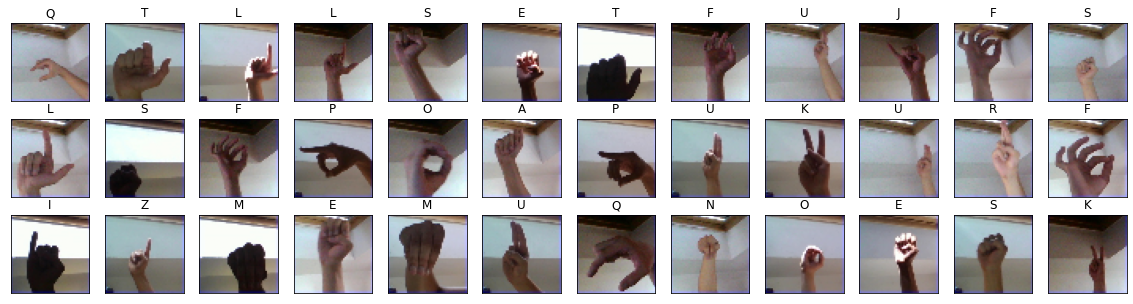

In [ ]:
# Store labels of dataset
#labels = ['A', 'B', 'C']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
          'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
          'S', 'T', 'U', 'W', 'X', 'Y', 'Z']

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()

In [ ]:
# The dataset is quite balanced!
print("Train/test samples per class:")
for i, label in enumerate(labels):
    num_train = sum(y_train==i)
    num_test = sum(y_test==i)
    print(f"{label}: {num_train} / {num_test} = {round(num_train/num_test, 2)}")

Train/test samples per class:
A: 2384 / 616 = 3.87
B: 2392 / 608 = 3.93
C: 2454 / 546 = 4.49
D: 2395 / 605 = 3.96
E: 2379 / 621 = 3.83
F: 2386 / 614 = 3.89
G: 2408 / 592 = 4.07
H: 2416 / 584 = 4.14
I: 2354 / 646 = 3.64
J: 2387 / 613 = 3.89
K: 2412 / 588 = 4.1
L: 2382 / 618 = 3.85
M: 2399 / 601 = 3.99
N: 2360 / 640 = 3.69
O: 2397 / 603 = 3.98
P: 2391 / 609 = 3.93
Q: 2409 / 591 = 4.08
R: 2398 / 602 = 3.98
S: 2396 / 604 = 3.97
T: 2418 / 582 = 4.15
U: 2436 / 564 = 4.32
W: 2429 / 571 = 4.25
X: 2410 / 590 = 4.08
Y: 2403 / 597 = 4.03
Z: 2405 / 595 = 4.04


## 3. Pre-processing: One-Hot Encoding

In [ ]:
from keras.utils import np_utils

# One-hot encode the training labels
y_train_OH = np_utils.to_categorical(y_train, len(labels))

# One-hot encode the test labels
y_test_OH = np_utils.to_categorical(y_test, len(labels))

## 4. Define Model 1: Simple CNN from Scratch

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=16,
                 kernel_size=3,
                 padding='same',
                 activation='relu',
                 input_shape=(50, 50, 3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) # 50/2 = 25
# Add a convolutional layer
model.add(Conv2D(filters=32,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) # 25/2 = 12
# Add a convolutional layer
model.add(Conv2D(filters=64,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) # 12/2 = 6
# Add a convolutional layer
model.add(Conv2D(filters=128,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) # 6/2 = 3
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))
# Summarize the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 50, 50, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 128)        

## 5. Train Model 1

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Early stopping when validation loss stops decreasing
# Arguments:
# - monitor: value to be monitored -> val_loss: loss of validaton data
# - mode: min -> training stops when monitored value stops decreasing
# - patience: number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [ ]:
# Train the model
hist = model.fit(x_train,
                 y_train_OH,
                 epochs=20,
                 validation_split=0.2,
                 batch_size=32,
                 shuffle=True,
                 callbacks=[early_stop])

## 6. Evaluate Model 1

<AxesSubplot:>

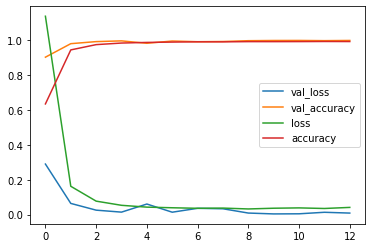

In [ ]:
# Plot learning curves
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Obtain accuracy on test set
score = model.evaluate(x=x_test,
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.998199999332428


In [ ]:
# Get predicted probabilities for test dataset
y_probs = model.predict(x_test)

# Get predicted labels for test dataset
#y_preds = model.predict_classes(x_test)
y_preds = np.argmax(y_probs, axis=1)

In [ ]:
outcome = pd.DataFrame(np.array([y_test,y_preds]).T, columns=['true', 'pred'])
id2label = {i:value for i,value in enumerate(labels)}
outcome = outcome[['true','pred']].replace(id2label)

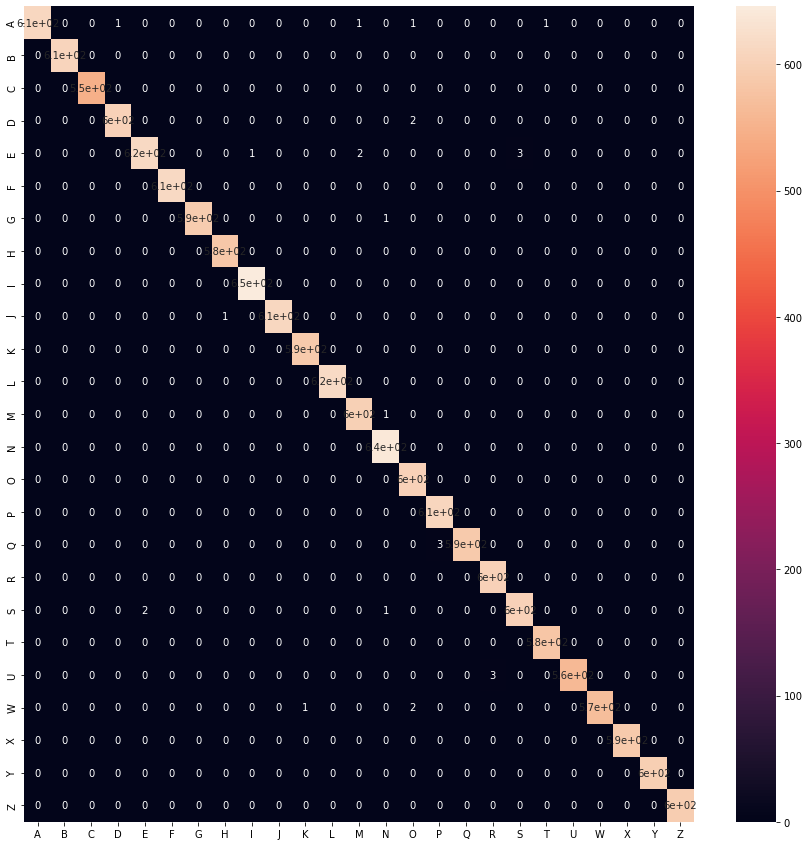

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(outcome['true'],outcome['pred']),
            xticklabels=labels,
            yticklabels=labels,
            annot=True);

In [ ]:
# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

In [ ]:
len(bad_test_idxs)

27

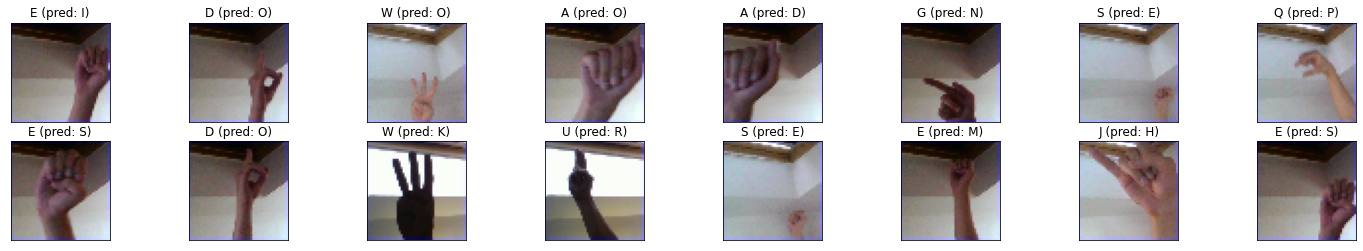

In [ ]:
# Print a random subset of mislabeled examples
fig = plt.figure(figsize=(25,4))
subset_size = 16
try:
    assert subset_size < len(bad_test_idxs)
except AssertionError:
    print("Use a smaller subset size!")
# Pick a random subset
z = int(np.random.rand()*(len(bad_test_idxs)-subset_size))
subset = bad_test_idxs[z:(z+subset_size)]
for i, idx in enumerate(subset):
    ax = fig.add_subplot(2, int(np.ceil(len(subset)/2)), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))

## 7. Define, Train & Evaluate Model 2: ResNet50/VGG16 with Transfer Learning

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential

#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
# Apply ResNet50-specific preprocessing
def preprocess(images, labels):
    return preprocess_input(images), labels

x_train_trans, y_train_OH = preprocess(x_train, y_train_OH)
x_test_trans, y_test_OH = preprocess(x_test, y_test_OH)

In [ ]:
x_train_trans.min()

-123.68

In [ ]:
x_train_trans.max()

-102.939

In [ ]:
x_train_trans.shape

(60000, 50, 50, 3)

In [ ]:
# Empty sequential model
transfer_model = Sequential()

# From Keras Applications, we can download many pre-trained models
# If we specify include_top=False, the original input/output layers
# are not imported.
# Note that we can specify our desired the input and output layer sizes!
pretrained_model= VGG16(include_top=False,
                   input_shape=(x_train.shape[1:]),
                   pooling='avg',
                   classes=len(labels),
                   weights='imagenet')
# Freeze layers; if not active, fine-tuning, else transfer learning
for layer in pretrained_model.layers:
    layer.trainable = False

# Add ResNet to empty sequential model
transfer_model.add(pretrained_model)

# Now, add the last layers of our model which map the extracted features
# too the classes - that's the classifier, what's really trained
transfer_model.add(Flatten())
transfer_model.add(Dense(512, activation='relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(len(labels), activation='softmax'))

# The complete model (fine-tuning) has 24/0.7 = 34x more parameters than the previous one!
# The transfer learning model has 1/0.7 = 1.4x more parameters than the previous one
transfer_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
Total params: 14,990,169
Trainable params: 275,481
Non-trainable params: 14,714,688
_____________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping when validation loss stops decreasing
# Arguments:
# - monitor: value to be monitored -> val_loss: loss of validaton data
# - mode: min -> training stops when monitored value stops decreasing
# - patience: number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile
#resnet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
transfer_model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

# Train/Fit
# I use less epochs, since in the previous model with 10 we were already good enough
history = transfer_model.fit(
                 x_train_trans,
                 #x_train,
                 y_train_OH,
                 epochs=20,
                 validation_split=0.2,
                 batch_size=32,
                 shuffle=True,
                 callbacks=[early_stop])

Epoch 1/20
1500/1500 [==============================] - 36s 19ms/step - loss: 3.3338 - accuracy: 0.0443 - val_loss: 3.1931 - val_accuracy: 0.0547
Epoch 2/20
1500/1500 [==============================] - 29s 19ms/step - loss: 3.1838 - accuracy: 0.0572 - val_loss: 3.1429 - val_accuracy: 0.0770
Epoch 3/20
1500/1500 [==============================] - 29s 19ms/step - loss: 3.1283 - accuracy: 0.0749 - val_loss: 3.0754 - val_accuracy: 0.0798
Epoch 4/20
1500/1500 [==============================] - 28s 19ms/step - loss: 3.0782 - accuracy: 0.0877 - val_loss: 3.0402 - val_accuracy: 0.1013
Epoch 5/20
1500/1500 [==============================] - 28s 19ms/step - loss: 3.0426 - accuracy: 0.0958 - val_loss: 2.9623 - val_accuracy: 0.1460
Epoch 6/20
1500/1500 [==============================] - 28s 19ms/step - loss: 3.0115 - accuracy: 0.1020 - val_loss: 2.9592 - val_accuracy: 0.1334
Epoch 7/20
1500/1500 [==============================] - 28s 19ms/step - loss: 2.9961 - accuracy: 0.1084 - val_loss: 2.9512 -

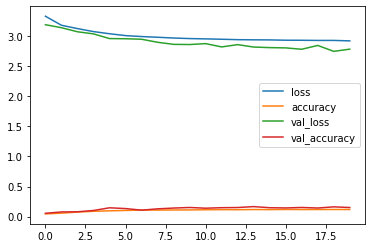

In [ ]:
# Plot learning curves
losses = pd.DataFrame(transfer_model.history.history)
losses.plot()

In [ ]:
# Obtain accuracy on test set
score = transfer_model.evaluate(x=x_test_trans,
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.14873333275318146


In [ ]:
# Get predicted probabilities for test dataset
y_probs = transfer_model.predict(x_test_trans)

# Get predicted labels for test dataset
#y_preds = transfer_model.predict_classes(x_test_trans)
y_preds = np.argmax(y_probs, axis=1)

469/469 [==============================] - 6s 13ms/step


In [ ]:
outcome = pd.DataFrame(np.array([y_test,y_preds]).T, columns=['true', 'pred'])
id2label = {i:value for i,value in enumerate(labels)}
outcome = outcome[['true','pred']].replace(id2label)

In [ ]:
#from sklearn.metrics import confusion_matrix
#import seaborn as sns

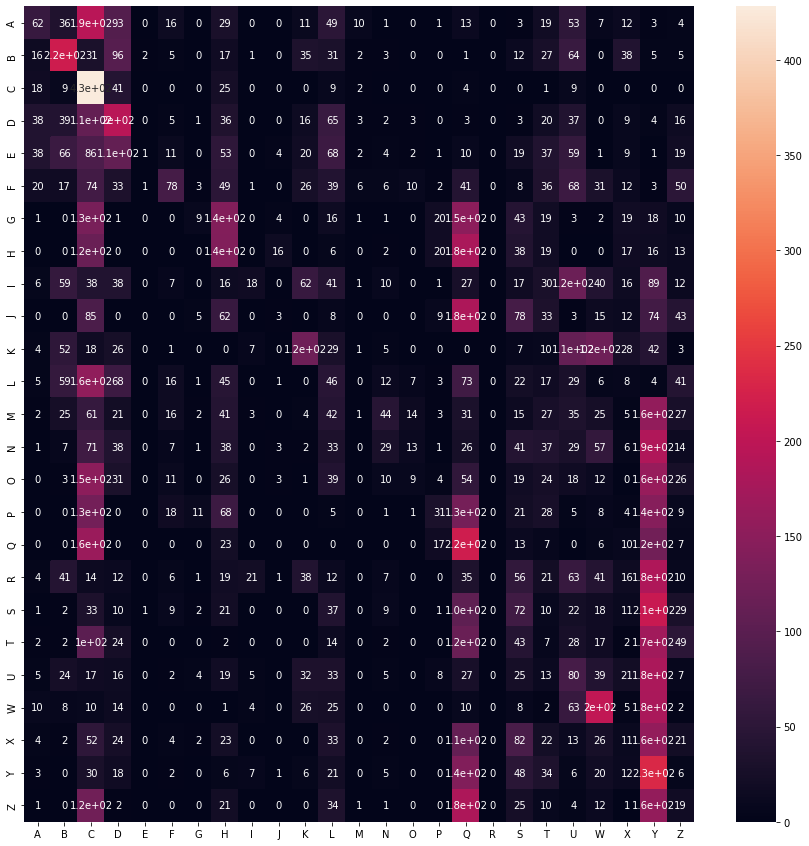

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(outcome['true'],outcome['pred']),
            xticklabels=labels,
            yticklabels=labels,
            annot=True);

In [ ]:
# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

In [ ]:
len(bad_test_idxs)

12769

## 8. Define, Train & Evaluate Model 3: Autoencoder + Random Forest

This model is probably a little bit peculiar. Since the neural networks seem to be working that well, I will try to use them to compress the images to a latent representation. Then, with that latent representation:

- I attach a classifier: a Random Forest.
- I plot the samples in a 2D space with manifold learning.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [ ]:
# Encoder: we compress the image
encoder = Sequential()
# First convolutional layer accepts image input
encoder.add(Conv2D(filters=32,
                 kernel_size=3,
                 padding='same',
                 activation='relu',
                 input_shape=(50, 50, 3)))
# Add a max pooling layer
encoder.add(MaxPooling2D(pool_size=(2, 2))) # 50/2 = 25
# Add a convolutional layer
encoder.add(Conv2D(filters=64,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
encoder.add(MaxPooling2D(pool_size=(2, 2))) # 25/2 = 12
# Add a convolutional layer
encoder.add(Conv2D(filters=128,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
encoder.add(MaxPooling2D(pool_size=(2, 2))) # 12/2 = 6
# Add a convolutional layer
encoder.add(Conv2D(filters=256,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))
# Add another max pooling layer
encoder.add(MaxPooling2D(pool_size=(2, 2))) # 6/2 = 3
# Compressed size: (batch, 3, 3, 256): 2304
# This flattening is not really necessary...
encoder.add(Flatten()) # (batch, 2304)
encoder.add(Dense(512)) # 2304 -> 512
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [ ]:
# Decoder: we expand the compressed representation
decoder = Sequential()
decoder.add(Dense(2304, input_shape=[512])) # 512 -> 2304
# Reshape: un-flatten the compressed representation
#decoder.add(Reshape([3, 3, 128], input_shape=[1152]))
decoder.add(Reshape([3, 3, 256]))
# (3, 3, 128) -> (6, 6, 64)
# W_out = ((W_in - 1) * strides[0] + kernel_size[0] - 2 * padding[0] + output_padding[0])
# W_out = (12-1)*2 + 3 - 2*P + OP
decoder.add(Conv2DTranspose(filters=128,
                              kernel_size=2,
                              strides=2,
                              padding="same",
                              activation="relu"))
# (6, 6, 64) -> (12, 12, 32)
decoder.add(Conv2DTranspose(filters=64,
                              kernel_size=2,
                              strides=2,
                              padding="same",
                              activation="relu"))
# (12, 12, 32) -> (25, 25, 16)
decoder.add(Conv2DTranspose(filters=32,
                              kernel_size=3,
                              strides=2,
                              padding="valid",
                              activation="relu"))
# (25, 25, 16) -> (50, 50, 3)
decoder.add(Conv2DTranspose(filters=3,
                              kernel_size=2,
                              strides=2,
                              padding="same",
                              activation="relu"))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2304)              1181952   
                                                                 
 reshape (Reshape)           (None, 3, 3, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 6, 6, 128)        131200    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 12, 12, 64)       32832     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 25, 25, 32)       18464     
 ranspose)                                                       
                                                      

In [ ]:
# Autoencoder
autoencoder = Sequential([encoder,decoder])

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512)               1568576   
                                                                 
 sequential_1 (Sequential)   (None, 50, 50, 3)         1364835   
                                                                 
Total params: 2,933,411
Trainable params: 2,933,411
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping when validation loss stops decreasing
# Arguments:
# - monitor: value to be monitored -> val_loss: loss of validaton data
# - mode: min -> training stops when monitored value stops decreasing
# - patience: number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
# We use the BINARY cross-entropy loss
# because we want to know whether the input and output images are equivalent
autoencoder.compile(loss='binary_crossentropy', # mse
                   optimizer='rmsprop')

In [ ]:
# Train
autoencoder.fit(x_train,
                x_train,
                epochs=20,
                validation_split=0.2,
                batch_size=32,
                shuffle=True,
                callbacks=[early_stop])

Epoch 1/20
1500/1500 [==============================] - 28s 13ms/step - loss: 0.6403 - val_loss: 0.5816
Epoch 2/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5808 - val_loss: 0.5814
Epoch 3/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5756 - val_loss: 0.5723
Epoch 4/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5724 - val_loss: 0.5688
Epoch 5/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5703 - val_loss: 0.5686
Epoch 6/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.5691 - val_loss: 0.5700
Epoch 7/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5684 - val_loss: 0.5680
Epoch 8/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5677 - val_loss: 0.5677
Epoch 9/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5672 - val_loss: 0.5677
Epoch 10/20
1500/1500 [==============================] - 16s 11m

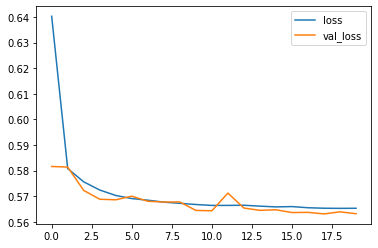

In [ ]:
# Plot learning curves
losses = pd.DataFrame(autoencoder.history.history)
losses.plot()

In [ ]:
x_test_enc_0 = encoder.predict(np.expand_dims(x_test[0], axis=0))
print(x_test_enc_0)

1/1 [==============================] - 0s 211ms/step
[[ 6.40319958e-02  4.25598323e-02 -2.92496029e-02 -1.83627084e-02
   6.63838023e-03  1.48624806e-02  3.08103021e-03 -8.04711413e-03
  -1.71038546e-02  1.01984339e-02  2.05837432e-02 -1.04462905e-02
   1.06213326e-02 -1.21105164e-02 -3.15149128e-02  1.79034937e-02
  -2.44427118e-02 -2.49820482e-03  8.46669264e-03 -8.72136932e-03
  -1.09536352e-03  9.62975249e-03  1.64383054e-02  2.18578316e-02
  -3.63428146e-04 -5.15409280e-04  5.83062768e-02  1.76272988e-02
   5.99097228e-03  2.05886140e-02  1.83729138e-02  2.04667188e-02
  -4.54637595e-03 -3.18964347e-02  9.30061750e-03 -1.13678277e-02
  -9.97534394e-03 -2.19083130e-02  1.25905387e-02  3.67516242e-02
   7.41622457e-03 -7.05099106e-03 -7.24637788e-03  3.35478187e-02
  -1.11051230e-02 -6.48978027e-03  5.55772334e-04  1.39158759e-02
  -1.87839586e-02 -2.00955328e-02  2.34440286e-02  6.70470437e-03
  -8.38374253e-04  1.91740822e-02 -3.78771797e-02  9.11231712e-03
  -1.41417691e-02  1.73

1/1 [==============================] - 0s 235ms/step


Text(0.5, 1.0, 'Reconstructed')

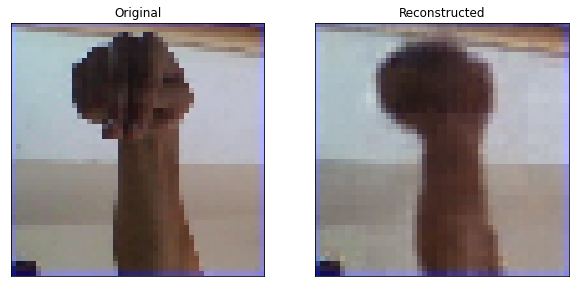

In [ ]:
x_org = x_test[2]
x_test_rec = autoencoder.predict(np.expand_dims(x_org, axis=0))

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(np.squeeze(x_org))
ax1.set_title("Original")
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.imshow(np.squeeze(x_test_rec[0]))
ax1.set_title("Reconstructed")

In [ ]:
x_train_enc = encoder.predict(x_train)
x_test_enc = encoder.predict(x_test)
print(x_train_enc.shape)
print(x_test_enc.shape)

469/469 [==============================] - 1s 3ms/step
(60000, 512)
(15000, 512)


In [ ]:
print(x_train_enc.shape)
print(x_test_enc.shape)
data_dict = {
    "x_train_enc": x_train_enc,
    "x_test_enc": x_test_enc,
    "y_train_OH": y_train_OH,
    "y_train": y_train,
    "y_test_OH": y_test_OH,
    "y_test": y_test,
    "labels": labels
}

(60000, 512)
(15000, 512)


In [ ]:
#import pickle
pickle.dump(data_dict, open('data_dict.pkl','wb')) # wb: write bytes

In [ ]:
data_dict = pickle.load(open('data_dict.pkl','rb')) # rb: read bytes
x_train_enc = data_dict["x_train_enc"]
x_test_enc = data_dict["x_test_enc"]
y_train_OH = data_dict["y_train_OH"]
y_train = data_dict["y_train"]
y_test_OH = data_dict["y_test_OH"]
y_test = data_dict["y_test"]
labels = data_dict["labels"]

In [ ]:
# Scale (for the logistic regression)
from sklearn.preprocessing import StandardScaler

scaler_enc = StandardScaler()
x_train_enc_scaled = scaler_enc.fit_transform(x_train_enc)
x_test_enc_scaled = scaler_enc.transform(x_test_enc)

In [ ]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params_grid_rf = {
  'max_depth': [10, 25],
  'n_estimators': [100, 150]
  #'min_samples_split': [5, 10]
}
params_grid_lr = {
  'penalty': ['l1', 'l2'],
  #'C': [0.01, 0.1, 1.0, 10]
  'C': [0.1, 1.0]
}

rfc = RandomForestClassifier(random_state=42,
                             max_depth=10,
                             n_jobs=-1,
                             n_estimators=100)
logr = LogisticRegression(random_state=42,
                          solver='saga',
                          multi_class='ovr',
                          n_jobs=-1)
# Notes on the scoring (look also at online docu):
# - can be a string or a callable; accuracy is in general bad, prefer others: 'f1', 'roc_auc'
# - if multi-class, there are one-versus-rest versions, e.g. 'roc_auc_ovr'
search = GridSearchCV(estimator = rfc, #logr, #rfc,
                       param_grid = params_grid_rf, #params_grid_lr, #params_grid_rf,
                       scoring='accuracy',
                       cv = 3, verbose = 10)

In [ ]:
#x_train_enc_scaled
#y_train

In [ ]:
#rfc.fit(x_train_enc_scaled, y_train)

In [ ]:
search.fit(x_train_enc_scaled, y_train)
search_best = search.best_estimator_

print(search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START max_depth=10, n_estimators=100..............................
[CV 1/3; 1/4] END max_depth=10, n_estimators=100;, score=0.856 total time=  14.4s
[CV 2/3; 1/4] START max_depth=10, n_estimators=100..............................
[CV 2/3; 1/4] END max_depth=10, n_estimators=100;, score=0.859 total time=  13.6s
[CV 3/3; 1/4] START max_depth=10, n_estimators=100..............................
[CV 3/3; 1/4] END max_depth=10, n_estimators=100;, score=0.866 total time=  13.2s
[CV 1/3; 2/4] START max_depth=10, n_estimators=150..............................
[CV 1/3; 2/4] END max_depth=10, n_estimators=150;, score=0.872 total time=  19.9s
[CV 2/3; 2/4] START max_depth=10, n_estimators=150..............................
[CV 2/3; 2/4] END max_depth=10, n_estimators=150;, score=0.873 total time=  20.8s
[CV 3/3; 2/4] START max_depth=10, n_estimators=150..............................
[CV 3/3; 2/4] END max_depth=10, n_estimators

In [ ]:
# Get predicted probabilities for test dataset
y_probs = search_best.predict_proba(x_test_enc_scaled)

# Get predicted labels for test dataset
y_preds = search_best.predict(x_test_enc_scaled)
#y_preds = np.argmax(yp, axis=1)

In [ ]:
y_preds.shape

(15000,)

In [ ]:
y_preds

array([ 2,  7, 13, ...,  1, 18, 16])

In [ ]:
outcome = pd.DataFrame(np.array([y_test,y_preds]).T, columns=['true', 'pred'])
id2label = {i:value for i,value in enumerate(labels)}
outcome = outcome[['true','pred']].replace(id2label)

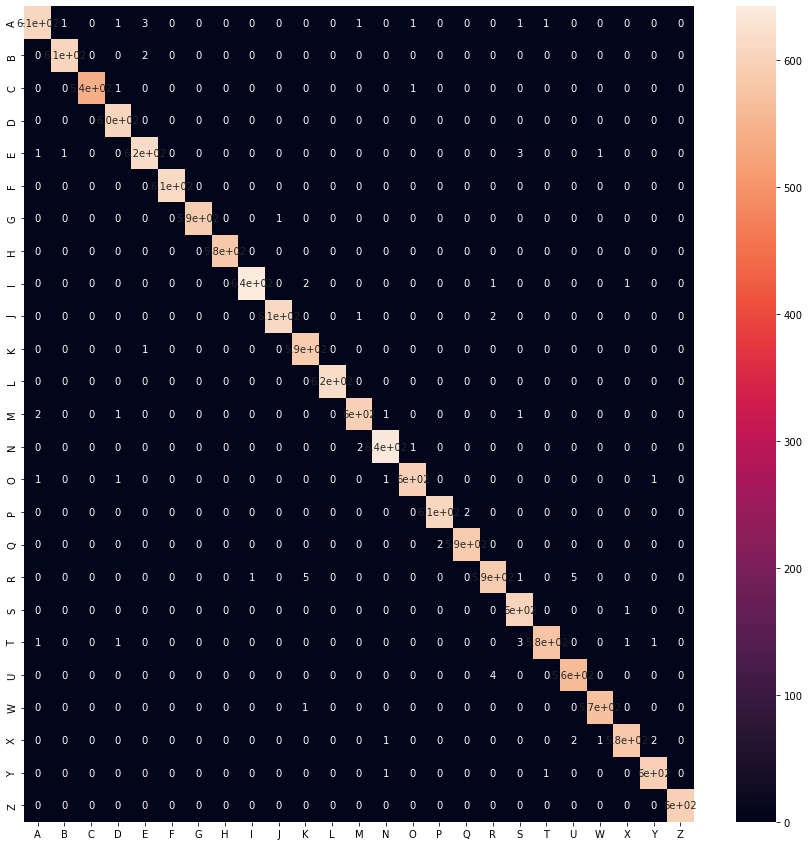

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(outcome['true'],outcome['pred']),
            xticklabels=labels,
            yticklabels=labels,
            annot=True);

In [ ]:
# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

In [ ]:
len(bad_test_idxs)

77

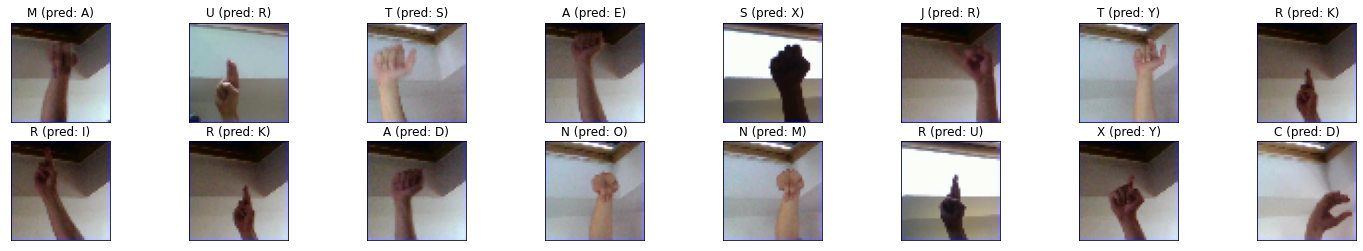

In [ ]:
# Print a random subset of mislabeled examples
fig = plt.figure(figsize=(25,4))
subset_size = 16
try:
    assert subset_size < len(bad_test_idxs)
except AssertionError:
    print("Use a smaller subset size!")
# Pick a random subset
z = int(np.random.rand()*(len(bad_test_idxs)-subset_size))
subset = bad_test_idxs[z:(z+subset_size)]
for i, idx in enumerate(subset):
    ax = fig.add_subplot(2, int(np.ceil(len(subset)/2)), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))